In [1]:
from skimage.data import brain

import numpy as np
import torch, torch.nn as nn
import cv2
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'true')

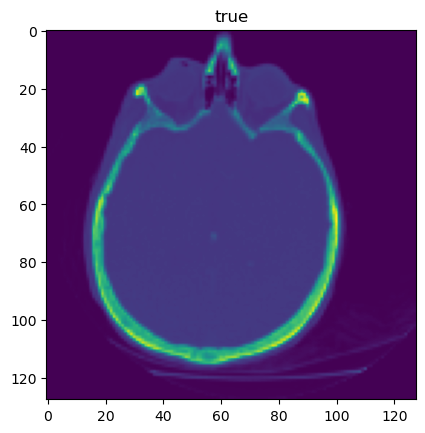

In [23]:
#def cv2disp(win, ima, xp, yp, sc):
#    cv2.imshow(win, rescale(ima, sc, False) * 1.0 / (np.max(ima) + 1e-15))
#    cv2.moveWindow(win, xp,yp )


#set up true object
nxd = 128
disp_scale = 4
brainimage = brain()
true_object = resize(brainimage[5,30:-1, :-30], (nxd, nxd), anti_aliasing=False)
#true_object_tensor = torch.from_numpy(true_object).float().unsqueeze(0).unsqueeze(0)

def np_to_torch(in_np):
    return torch.from_numpy(in_np).float().unsqueeze(0).unsqueeze(0)

def torch_to_np(in_torch):
    return np.squeeze(in_torch.detach().cpu().numpy())

true_object_tensor = np_to_torch(true_object)

plt.imshow(true_object)
plt.title("true")

## Iterative Image Reconstruction Maximum Likelihood - Expecation Maximisation (ML-EM) algorithm

$$\mathbf{x}^{k+1} = \frac{x^k}{\mathbf{A}^T \mathbf{1}} \mathbf{A}^T \frac{\mathbf{m}}{\mathbf{Ax}^k}$$ 
where $\mathbf{A}^T \mathbf{1}$ is the backprojection of the unit sinogram, the sensitivity image.

Now, we will use a CNN between each update such that the endpoint iteration agrees with the ground truth image we have here. Matrix A is the forward projection matrix simulating the line integral.

For each pixel (given an x and y direction), consider all aximuthal angles $\phi$ in the sinogram. With these values of $x,y$, and  $\phi$, find the 1D position $y'$ on the sinogram. 

$$ y' = -x \sin(\phi) + y \cos(\phi)$$

In [8]:
#create system model A as a matrix.
#nxd, numbe rof samples in image
#specify the number of radial samples on the sinogram that we are projecting to
# how many projection angles there are
def make_system_matrix(nxd, nrd, nphi):
    system_matrix = torch.zeros(nrd * nphi, nxd * nxd) # rows = num sinobins, #column = num image pixels
    # each column correpsonds to the entire sinogram of a given pixel
    # each row of A corresponds to a sensitvity iamge for each sinogram bin!, 
    #   a straight white line through the pixel in the image-space!
    # forward projection is in the sinogram space
    for xv in range(nxd):
        for yv in range(nxd): #selected pizel (xv, yv)
            for ph in range(nphi): #now for each angle, project that pixel
                yp = -(xv - (nxd * 0.5)) * np.sin(ph * np.pi/ nphi) + (yv - (nxd * 0.5)) * np.cos(ph * np.pi / nphi) #center to the pixel
                yp_bin = int(yp + nrd/ 2.0)
                system_matrix[yp_bin + ph * nrd, xv + yv *nxd] = 1.0
    return system_matrix

In [9]:
nphi = 120
#only 120 angles
nrd = int(np.sqrt(2*(128**2)))

In [20]:
print(nrd)
print(int(nxd * 1.42))

181
181


In [10]:
out = make_system_matrix(nxd, nrd, nphi)

In [11]:
def fp_system(image, sys_mat, nxd, nrd, nphi):
    return torch.reshape(torch.mm(sys_mat, torch.reshape(image, (nxd*nxd, 1))), (nphi, nrd))

def bp_system(sino, sys_mat, nxd, nrd, nphi):
    return torch.reshape(torch.mm(sys_mat.T, torch.reshape(sino, (nrd * nphi, 1))), (nxd, nxd))


cpu


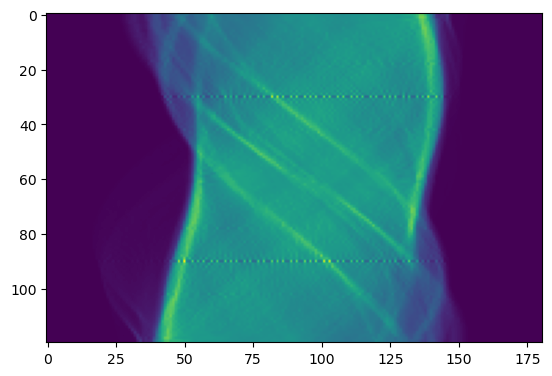

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#sysmat = make_system_matrix(nxd, nrd, nphi).to(device)

true_sinogram = fp_system(true_object_tensor, out, nxd, nrd, nphi) #a tensor

plt.imshow(torch_to_np(true_sinogram))

### this has been a crude, nearest neighbor forward projection. Could do interpolation

## Now for iterative reconstruction

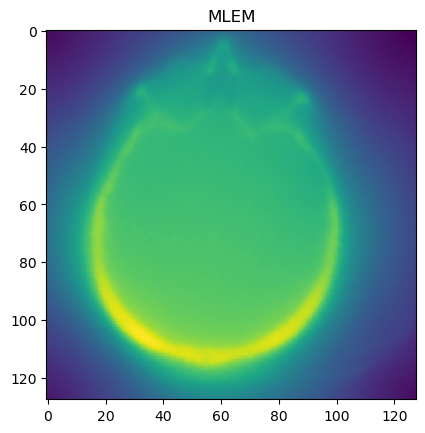

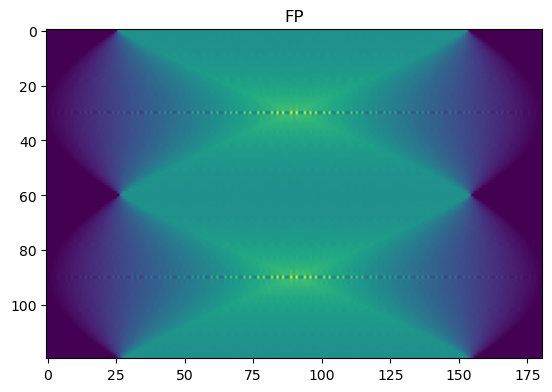

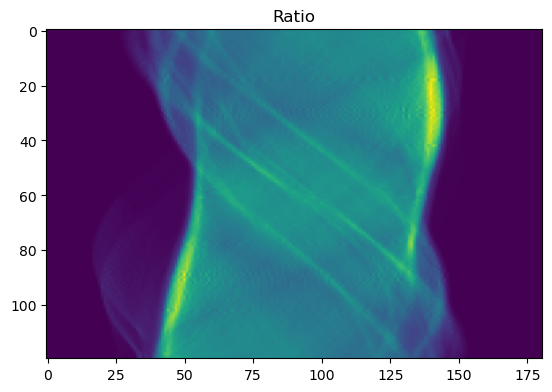

it 0


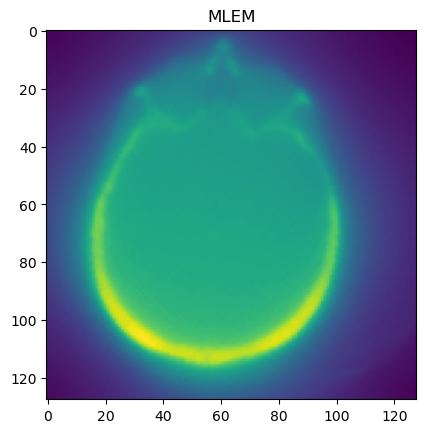

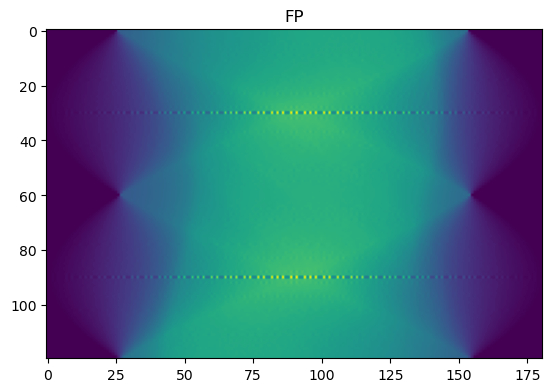

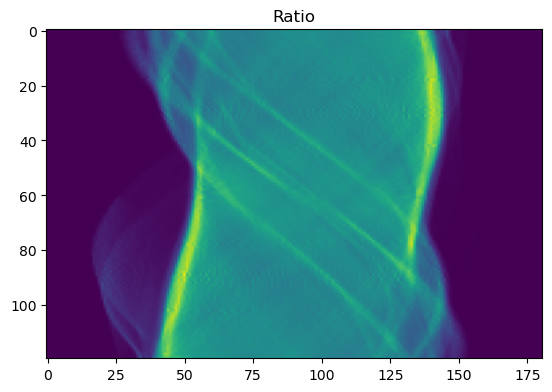

it 1


In [30]:
class MLEM_NET(nn.Module):
    def __init__(self, sino_for_reconstruction, num_its):
        super(MLEM_NET, self).__init__()
        self.num_its = num_its
        self.sino_ones = torch.ones_like(sino_for_reconstruction)
        self.sens_image = bp_system(self.sino_ones, out, nxd, nrd, nphi)
    
    def forward(self, sino_for_reconstruction):
        recon = torch.ones(nxd, nxd).to(device)
        #going to iterate to update recon, then use cnn to 

        for it in range(self.num_its):
            fpsino = fp_system(recon, out, nxd, nrd, nphi)
            ratio = sino_for_reconstruction / (fpsino + 1.0e-9)
            correction = bp_system(ratio, out, nxd, nrd, nphi) / (self.sens_image + 1.0e-9)
            recon = recon * correction
            plt.imshow(torch_to_np(recon))
            plt.title("MLEM")
            plt.show()

            plt.imshow(torch_to_np(fpsino))
            plt.title("FP")
            plt.show()

            plt.imshow(torch_to_np(ratio))
            plt.title("Ratio")
            plt.show()
            print("it", it)
        return recon


#instantiate network class
core_iterations = 2 #could do more
deepnet = MLEM_NET(true_sinogram, core_iterations).to(device)
mlem_recon = deepnet(true_sinogram)

# Now add the CNN

In [31]:
class NEW_CNN(nn.Module):
    def __init__(self):
        super(NEW_CNN, self).__init__()
        self.CNN = nn.Sequential(
            nn.Conv2d(1,8,7, padding = (3,3)), nn.PReLU(), #1 input image, 8 channels(output images), 7x7 kernels, zero padding
            nn.Conv2d(8,8,7, padding = (3,3)), nn.PReLU(), #8 channels, 8 kernels?
            nn.Conv2d(8,8,7, padding = (3,3)), nn.PReLU(),
            nn.Conv2d(8,8,7, padding = (3,3)), nn.PReLU(),
            nn.Conv2d(8,1,7, padding = (3,3)), nn.PReLU() #single kernel with 8 channels/feature maps
        )
    def forward(self, x):
        x = torch.squeeze(self.CNN(x.unsqueeze(0).unsqueeze(0)))
        return x
cnn = NEW_CNN().to(device)

In [45]:
class MLEM_CNN(nn.Module):
    def __init__(self, cnn, sino_for_reconstruction, num_its):
        super(MLEM_CNN, self).__init__()
        self.num_its = num_its
        self.sino_ones = torch.ones_like(sino_for_reconstruction)
        self.sens_image = bp_system(self.sino_ones, out, nxd, nrd, nphi)
        self.cnn = cnn
    
    def forward(self, sino_for_reconstruction):
        recon = torch.ones(nxd, nxd).to(device)
        #going to iterate to update recon, then use cnn to 

        for it in range(self.num_its):
            fpsino = fp_system(recon, out, nxd, nrd, nphi)
            ratio = sino_for_reconstruction / (fpsino + 1.0e-9)
            correction = bp_system(ratio, out, nxd, nrd, nphi) / (self.sens_image + 1.0e-9)
            recon = recon * correction
            # inter update cnn
            recon = torch.abs(recon + self.cnn(recon)) #abs because MLEM is strictly non-negative
        """
        plt.imshow(torch_to_np(recon))
        plt.title("MLEM")
        plt.show()

        plt.imshow(torch_to_np(fpsino))
        plt.title("FP")
        plt.show()

        plt.imshow(torch_to_np(ratio))
        plt.title("Ratio")
        plt.show()
        """
        return recon


#instantiate network class
core_iterations = 2 #could do more
deepnet_cnn = MLEM_CNN(cnn, true_sinogram, core_iterations).to(device)
mlem_cnn = deepnet_cnn(true_sinogram)


loss_fun = nn.MSELoss()
optimiser = torch.optim.Adam(deepnet_cnn.parameters(), lr = 0.001)

train_loss = list()
epochs = 100
for ep in range(epochs):
    rec_out = deepnet_cnn(true_sinogram)
    loss = loss_fun(rec_out, torch.squeeze(true_object_tensor))
    train_loss.append(loss.item())
    loss.backward() # find the gradients
    optimiser.step() # does the update
    optimiser.zero_grad() #set gradients to zero
    print('epoch %d training loss = %f' % (ep, train_loss[-1]))



epoch 0 training loss = 0.004784
epoch 1 training loss = 0.005303
epoch 2 training loss = 0.005647
epoch 3 training loss = 0.005107
epoch 4 training loss = 0.005276
epoch 5 training loss = 0.005391
epoch 6 training loss = 0.005411
epoch 7 training loss = 0.005274
epoch 8 training loss = 0.005124
epoch 9 training loss = 0.004955
epoch 10 training loss = 0.004778
epoch 11 training loss = 0.004764
epoch 12 training loss = 0.004970
epoch 13 training loss = 0.004956
epoch 14 training loss = 0.004759
epoch 15 training loss = 0.004615
epoch 16 training loss = 0.004581
epoch 17 training loss = 0.004610
epoch 18 training loss = 0.004557
epoch 19 training loss = 0.004466
epoch 20 training loss = 0.004348
epoch 21 training loss = 0.004225
epoch 22 training loss = 0.004065
epoch 23 training loss = 0.003968
epoch 24 training loss = 0.003772
epoch 25 training loss = 0.003734
epoch 26 training loss = 0.003554
epoch 27 training loss = 0.003378
epoch 28 training loss = 0.003086
epoch 29 training loss =

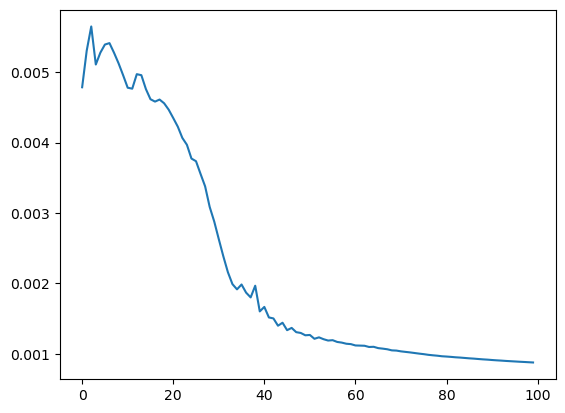

In [49]:
plt.plot(np.arange(epochs), np.array(train_loss))

# final reconstruction

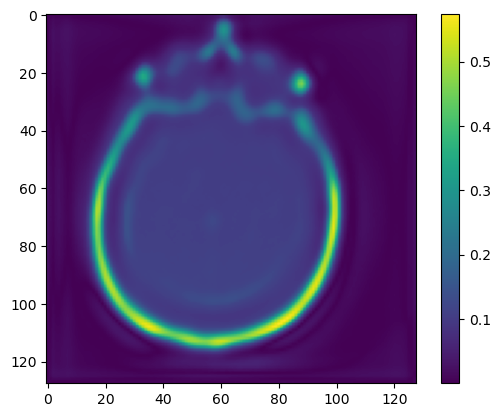

In [56]:
plt.imshow(torch_to_np(rec_out))
plt.colorbar()

# Residual of final - true object

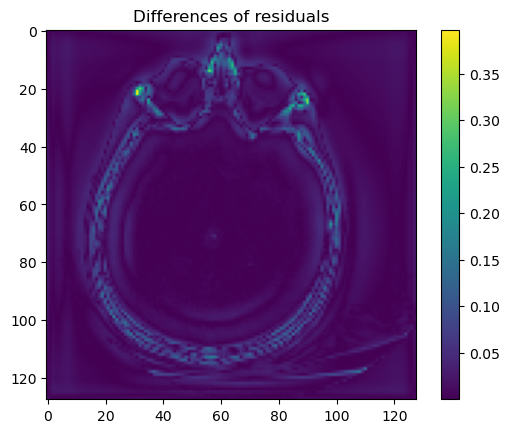

In [54]:
plt.imshow(np.sqrt((torch_to_np(rec_out) - true_object)**2))
plt.title("Differences of residuals")
plt.colorbar()